# Notebook 03 - Modelisation

## Projet : Detection de Fraudes - Transactions par Cheque

**M2 SISE - Fouille de Donnees Massives**

---

### Objectifs de ce notebook

1. Etablir un modele baseline
2. Tester differentes techniques de resampling (SMOTE, ADASYN, Under-sampling)
3. Comparer plusieurs algorithmes (Random Forest, XGBoost, LightGBM)
4. Optimiser les hyperparametres
5. Evaluer sur l'ensemble de test

**Objectif principal**: Maximiser la F-mesure

---

## 1. Configuration et imports

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
from datetime import datetime

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)



In [1]:
# Import des modules du projet
import sys
sys.path.append('..')

from config.config import (
    PROCESSED_DATA_DIR, FIGURES_DIR, MODELS_DIR,
    RANDOM_STATE, TARGET_COLUMN
)
from src.evaluation import (
    compute_all_metrics, print_metrics, plot_confusion_matrix,
    plot_roc_curve, plot_precision_recall_curve,
    compare_models, plot_model_comparison,
    find_best_threshold, plot_threshold_analysis
)

print(f"Random state: {RANDOM_STATE}")

Random state: 42


## 2. Chargement des donnees

In [3]:
# Charger les donnees preprocessees (sans scaling pour les arbres)
X_train = pd.read_pickle(PROCESSED_DATA_DIR / 'X_train.pkl')
X_test = pd.read_pickle(PROCESSED_DATA_DIR / 'X_test.pkl')
y_train = pd.read_pickle(PROCESSED_DATA_DIR / 'y_train.pkl')
y_test = pd.read_pickle(PROCESSED_DATA_DIR / 'y_test.pkl')

print("Donnees chargees:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_train: {y_train.shape} - Taux fraude: {y_train.mean()*100:.2f}%")
print(f"   y_test:  {y_test.shape} - Taux fraude: {y_test.mean()*100:.2f}%")

Donnees chargees:
   X_train: (3899362, 18)
   X_test:  (747411, 18)
   y_train: (3899362,) - Taux fraude: 0.60%
   y_test:  (747411,) - Taux fraude: 0.88%


In [4]:
# Dictionnaire pour stocker tous les resultats
all_results = {}

## 3. METHODE 1: Baseline - Random Forest sans resampling

Premier modele de reference pour comparer les ameliorations.

In [5]:
print("="*70)
print("METHODE 1: Random Forest Baseline (sans resampling)")
print("="*70)

# Entrainement
start_time = time.time()

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

print("Entrainement en cours...")
rf_baseline.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_baseline = rf_baseline.predict(X_test)
y_proba_baseline = rf_baseline.predict_proba(X_test)[:, 1]

# Evaluation
metrics_baseline = compute_all_metrics(y_test, y_pred_baseline, y_proba_baseline)
print_metrics(metrics_baseline, "RF Baseline")

# Sauvegarder les resultats
all_results['1. RF Baseline'] = metrics_baseline

METHODE 1: Random Forest Baseline (sans resampling)
Entrainement en cours...
Temps d'entrainement: 645.9s

RESULTATS: RF Baseline

[Matrice de confusion]
   TP (Fraudes detectees):            121
   TN (Normales correctes):       740,782
   FP (Fausses alertes):               56
   FN (Fraudes manquees):           6,452

[Metriques principales]
   F1-Score:    0.0359  <-- METRIQUE A OPTIMISER
   Precision:   0.6836
   Recall:      0.0184
   Accuracy:    0.9913
   Specificite: 0.9999

[Metriques probabilistes]
   ROC-AUC:     0.7426
   Avg Prec:    0.0906


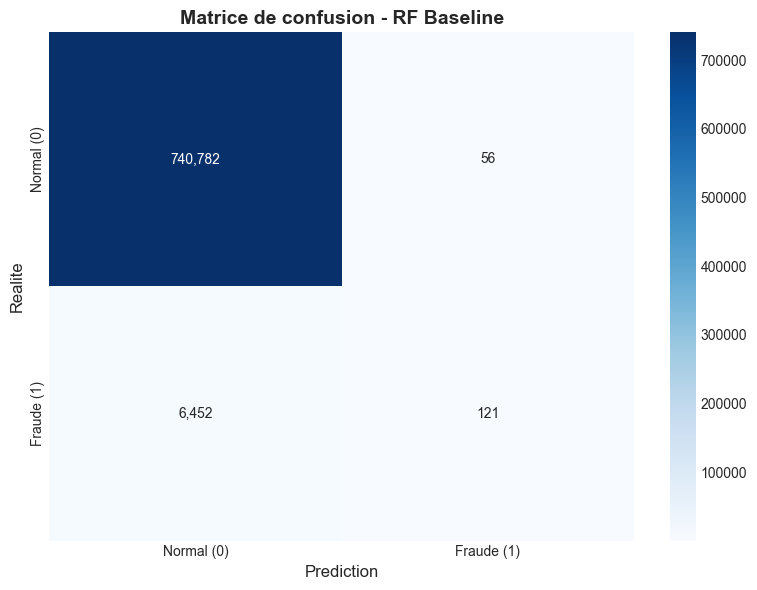

In [6]:
# Matrice de confusion du baseline
plot_confusion_matrix(y_test, y_pred_baseline, "RF Baseline", save=True)

### Interpretation du Baseline

Le modele baseline nous donne un point de reference. Observez:
- Le nombre de fraudes detectees (TP) vs manquees (FN)
- Le F1-Score obtenu sans aucun traitement du desequilibre

## 4. METHODE 2: Random Forest + SMOTE (Oversampling)

In [7]:
print("="*70)
print("METHODE 2: Random Forest + SMOTE")
print("="*70)

# Application de SMOTE
print("\nApplication de SMOTE...")
smote = SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)

start_time = time.time()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
smote_time = time.time() - start_time

print(f"Avant SMOTE: {len(y_train):,} echantillons ({y_train.sum():,} fraudes)")
print(f"Apres SMOTE: {len(y_train_smote):,} echantillons ({y_train_smote.sum():,} fraudes)")
print(f"Temps SMOTE: {smote_time:.1f}s")

# Entrainement
print("\nEntrainement en cours...")
start_time = time.time()

rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_smote.fit(X_train_smote, y_train_smote)
train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_smote = rf_smote.predict(X_test)
y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]

# Evaluation
metrics_smote = compute_all_metrics(y_test, y_pred_smote, y_proba_smote)
print_metrics(metrics_smote, "RF + SMOTE")

all_results['2. RF + SMOTE'] = metrics_smote

METHODE 2: Random Forest + SMOTE

Application de SMOTE...
Avant SMOTE: 3,899,362 echantillons (23,422 fraudes)
Apres SMOTE: 5,813,910 echantillons (1,937,970 fraudes)
Temps SMOTE: 11.0s

Entrainement en cours...
Temps d'entrainement: 827.5s

RESULTATS: RF + SMOTE

[Matrice de confusion]
   TP (Fraudes detectees):          2,668
   TN (Normales correctes):       639,686
   FP (Fausses alertes):          101,152
   FN (Fraudes manquees):           3,905

[Metriques principales]
   F1-Score:    0.0483  <-- METRIQUE A OPTIMISER
   Precision:   0.0257
   Recall:      0.4059
   Accuracy:    0.8594
   Specificite: 0.8635

[Metriques probabilistes]
   ROC-AUC:     0.7182
   Avg Prec:    0.0471


In [8]:
# Nettoyage memoire
del X_train_smote, y_train_smote
import gc
gc.collect()

5277

## 5. METHODE 3: XGBoost avec class_weight (Cost-Sensitive)

In [9]:
print("="*70)
print("METHODE 3: XGBoost avec scale_pos_weight (Cost-Sensitive)")
print("="*70)

# Calculer le ratio de desequilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")

# Entrainement
print("\nEntrainement en cours...")
start_time = time.time()

xgb_weighted = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

xgb_weighted.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_xgb = xgb_weighted.predict(X_test)
y_proba_xgb = xgb_weighted.predict_proba(X_test)[:, 1]

# Evaluation
metrics_xgb = compute_all_metrics(y_test, y_pred_xgb, y_proba_xgb)
print_metrics(metrics_xgb, "XGBoost Weighted")

all_results['3. XGBoost Weighted'] = metrics_xgb

METHODE 3: XGBoost avec scale_pos_weight (Cost-Sensitive)

scale_pos_weight: 165.48

Entrainement en cours...
Temps d'entrainement: 32.2s

RESULTATS: XGBoost Weighted

[Matrice de confusion]
   TP (Fraudes detectees):          4,590
   TN (Normales correctes):       486,848
   FP (Fausses alertes):          253,990
   FN (Fraudes manquees):           1,983

[Metriques principales]
   F1-Score:    0.0346  <-- METRIQUE A OPTIMISER
   Precision:   0.0178
   Recall:      0.6983
   Accuracy:    0.6575
   Specificite: 0.6572

[Metriques probabilistes]
   ROC-AUC:     0.7517
   Avg Prec:    0.0798


## 6. METHODE 4: LightGBM + ADASYN

In [10]:
print("="*70)
print("METHODE 4: LightGBM + ADASYN")
print("="*70)

# Application de ADASYN
print("\nApplication de ADASYN...")
adasyn = ADASYN(sampling_strategy=0.5, random_state=RANDOM_STATE)

start_time = time.time()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
adasyn_time = time.time() - start_time

print(f"Avant ADASYN: {len(y_train):,} echantillons ({y_train.sum():,} fraudes)")
print(f"Apres ADASYN: {len(y_train_adasyn):,} echantillons ({y_train_adasyn.sum():,} fraudes)")
print(f"Temps ADASYN: {adasyn_time:.1f}s")

# Entrainement LightGBM
print("\nEntrainement LightGBM...")
start_time = time.time()

lgbm_adasyn = LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

lgbm_adasyn.fit(X_train_adasyn, y_train_adasyn)
train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_lgbm = lgbm_adasyn.predict(X_test)
y_proba_lgbm = lgbm_adasyn.predict_proba(X_test)[:, 1]

# Evaluation
metrics_lgbm = compute_all_metrics(y_test, y_pred_lgbm, y_proba_lgbm)
print_metrics(metrics_lgbm, "LightGBM + ADASYN")

all_results['4. LightGBM + ADASYN'] = metrics_lgbm

METHODE 4: LightGBM + ADASYN

Application de ADASYN...
Avant ADASYN: 3,899,362 echantillons (23,422 fraudes)
Apres ADASYN: 5,811,846 echantillons (1,935,906 fraudes)
Temps ADASYN: 428.3s

Entrainement LightGBM...
Temps d'entrainement: 49.0s

RESULTATS: LightGBM + ADASYN

[Matrice de confusion]
   TP (Fraudes detectees):          1,937
   TN (Normales correctes):       692,795
   FP (Fausses alertes):           48,043
   FN (Fraudes manquees):           4,636

[Metriques principales]
   F1-Score:    0.0685  <-- METRIQUE A OPTIMISER
   Precision:   0.0388
   Recall:      0.2947
   Accuracy:    0.9295
   Specificite: 0.9352

[Metriques probabilistes]
   ROC-AUC:     0.7219
   Avg Prec:    0.0603


In [11]:
# Nettoyage memoire
del X_train_adasyn, y_train_adasyn
gc.collect()

47

## 7. METHODE 5: Random Forest + Random UnderSampling

In [12]:
print("="*70)
print("METHODE 5: Random Forest + Random UnderSampling")
print("="*70)

# Application du Random UnderSampling
print("\nApplication de Random UnderSampling...")
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)

start_time = time.time()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
rus_time = time.time() - start_time

print(f"Avant RUS: {len(y_train):,} echantillons ({y_train.sum():,} fraudes)")
print(f"Apres RUS: {len(y_train_rus):,} echantillons ({y_train_rus.sum():,} fraudes)")
print(f"Temps RUS: {rus_time:.1f}s")

# Entrainement
print("\nEntrainement en cours...")
start_time = time.time()

rf_rus = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_rus.fit(X_train_rus, y_train_rus)
train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_rus = rf_rus.predict(X_test)
y_proba_rus = rf_rus.predict_proba(X_test)[:, 1]

# Evaluation
metrics_rus = compute_all_metrics(y_test, y_pred_rus, y_proba_rus)
print_metrics(metrics_rus, "RF + UnderSampling")

all_results['5. RF + UnderSampling'] = metrics_rus

METHODE 5: Random Forest + Random UnderSampling

Application de Random UnderSampling...
Avant RUS: 3,899,362 echantillons (23,422 fraudes)
Apres RUS: 70,266 echantillons (23,422 fraudes)
Temps RUS: 2.1s

Entrainement en cours...
Temps d'entrainement: 9.5s

RESULTATS: RF + UnderSampling

[Matrice de confusion]
   TP (Fraudes detectees):          3,566
   TN (Normales correctes):       597,735
   FP (Fausses alertes):          143,103
   FN (Fraudes manquees):           3,007

[Metriques principales]
   F1-Score:    0.0465  <-- METRIQUE A OPTIMISER
   Precision:   0.0243
   Recall:      0.5425
   Accuracy:    0.8045
   Specificite: 0.8068

[Metriques probabilistes]
   ROC-AUC:     0.7459
   Avg Prec:    0.0621


In [13]:
# Nettoyage memoire
del X_train_rus, y_train_rus
gc.collect()

87

## 8. METHODE 6 (Bonus): SMOTE + Tomek Links (Combinaison)

In [14]:
"""print("="*70)
print("METHODE 6: XGBoost + SMOTETomek (Combinaison Over/Under)")
print("="*70)

# SMOTETomek combine SMOTE (oversampling) et Tomek Links (nettoyage)
print("\nApplication de SMOTETomek...")
smotetomek = SMOTETomek(sampling_strategy=0.5, random_state=RANDOM_STATE, n_jobs=-1)

start_time = time.time()
X_train_st, y_train_st = smotetomek.fit_resample(X_train, y_train)
st_time = time.time() - start_time

print(f"Avant SMOTETomek: {len(y_train):,} echantillons ({y_train.sum():,} fraudes)")
print(f"Apres SMOTETomek: {len(y_train_st):,} echantillons ({y_train_st.sum():,} fraudes)")
print(f"Temps SMOTETomek: {st_time:.1f}s")

# Entrainement XGBoost
print("\nEntrainement XGBoost...")
start_time = time.time()

xgb_st = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

xgb_st.fit(X_train_st, y_train_st)
train_time = time.time() - start_time
print(f"Temps d'entrainement: {train_time:.1f}s")

# Predictions
y_pred_st = xgb_st.predict(X_test)
y_proba_st = xgb_st.predict_proba(X_test)[:, 1]

# Evaluation
metrics_st = compute_all_metrics(y_test, y_pred_st, y_proba_st)
print_metrics(metrics_st, "XGBoost + SMOTETomek")

all_results['6. XGBoost + SMOTETomek'] = metrics_st """

'print("="*70)\nprint("METHODE 6: XGBoost + SMOTETomek (Combinaison Over/Under)")\nprint("="*70)\n\n# SMOTETomek combine SMOTE (oversampling) et Tomek Links (nettoyage)\nprint("\nApplication de SMOTETomek...")\nsmotetomek = SMOTETomek(sampling_strategy=0.5, random_state=RANDOM_STATE, n_jobs=-1)\n\nstart_time = time.time()\nX_train_st, y_train_st = smotetomek.fit_resample(X_train, y_train)\nst_time = time.time() - start_time\n\nprint(f"Avant SMOTETomek: {len(y_train):,} echantillons ({y_train.sum():,} fraudes)")\nprint(f"Apres SMOTETomek: {len(y_train_st):,} echantillons ({y_train_st.sum():,} fraudes)")\nprint(f"Temps SMOTETomek: {st_time:.1f}s")\n\n# Entrainement XGBoost\nprint("\nEntrainement XGBoost...")\nstart_time = time.time()\n\nxgb_st = XGBClassifier(\n    n_estimators=100,\n    max_depth=6,\n    learning_rate=0.1,\n    random_state=RANDOM_STATE,\n    n_jobs=-1,\n    use_label_encoder=False,\n    eval_metric=\'logloss\',\n    verbosity=0\n)\n\nxgb_st.fit(X_train_st, y_train_st)\

In [ ]:
"""# Nettoyage memoire
del X_train_st, y_train_st
gc.collect()"""

## 9. Comparaison des modeles

In [16]:
# Tableau comparatif
print("\n" + "="*80)
print("COMPARAISON DE TOUTES LES METHODES")
print("="*80)

comparison_df = compare_models(all_results)
print("\n")
print(comparison_df.to_string(index=False))


COMPARAISON DE TOUTES LES METHODES


               Modele  F1-Score  Precision   Recall  ROC-AUC  Accuracy
 4. LightGBM + ADASYN  0.068502   0.038756 0.294690 0.721928  0.929518
        2. RF + SMOTE  0.048336   0.025698 0.405903 0.718155  0.859439
5. RF + UnderSampling  0.046541   0.024313 0.542522 0.745908  0.804512
       1. RF Baseline  0.035852   0.683616 0.018409 0.742613  0.991293
  3. XGBoost Weighted  0.034622   0.017751 0.698311 0.751661  0.657520


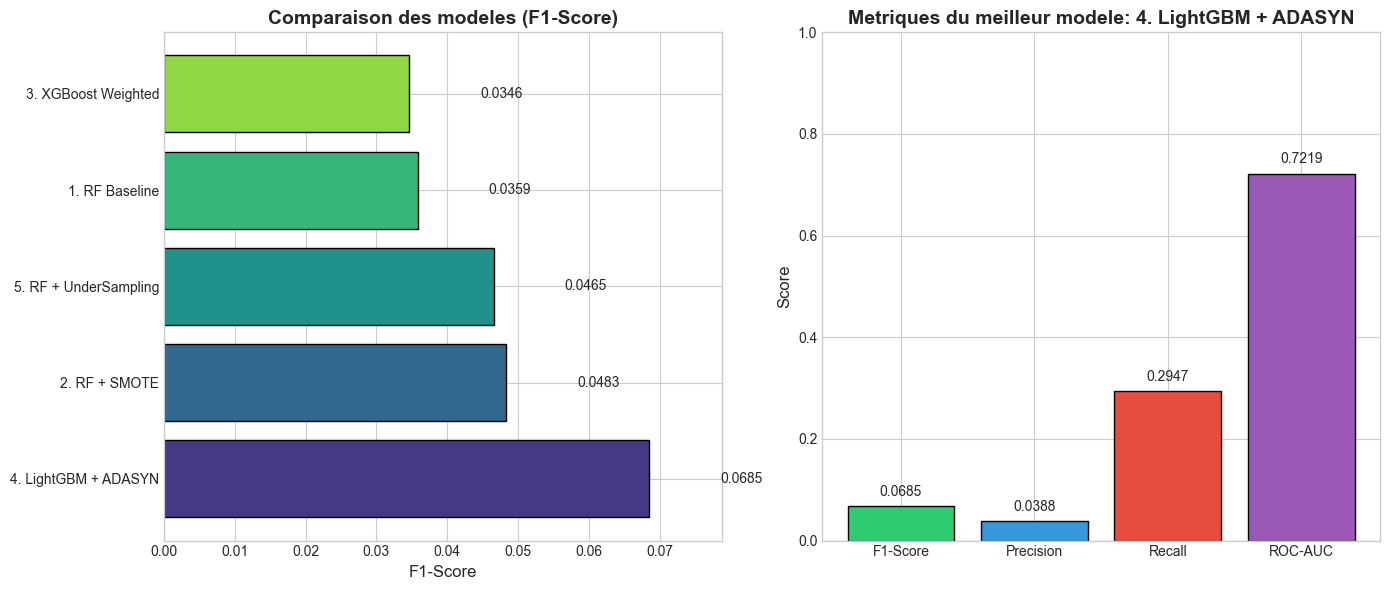

In [17]:
# Visualisation
plot_model_comparison(comparison_df, save=True)

In [18]:
# Identifier le meilleur modele
best_model_name = comparison_df.iloc[0]['Modele']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\nMEILLEUR MODELE: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")


MEILLEUR MODELE: 4. LightGBM + ADASYN
F1-Score: 0.0685


## 10. Analyse du meilleur modele

In [19]:
# Selectionner les predictions du meilleur modele
# (a adapter selon le meilleur modele identifie)

best_models_dict = {
    '1. RF Baseline': (y_pred_baseline, y_proba_baseline, rf_baseline),
    '2. RF + SMOTE': (y_pred_smote, y_proba_smote, rf_smote),
    '3. XGBoost Weighted': (y_pred_xgb, y_proba_xgb, xgb_weighted),
    '4. LightGBM + ADASYN': (y_pred_lgbm, y_proba_lgbm, lgbm_adasyn),
    #'5. RF + UnderSampling': (y_pred_rus, y_proba_rus, rf_rus),
    #'6. XGBoost + SMOTETomek': (y_pred_st, y_proba_st, xgb_st),
}

y_pred_best, y_proba_best, best_model = best_models_dict[best_model_name]
print(f"Analyse detaillee de: {best_model_name}")

Analyse detaillee de: 4. LightGBM + ADASYN


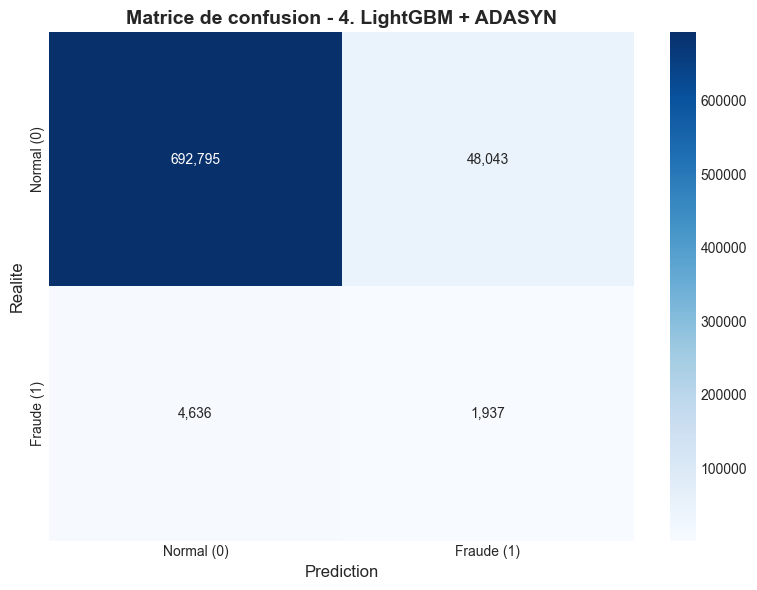

In [20]:
# Matrice de confusion du meilleur modele
plot_confusion_matrix(y_test, y_pred_best, best_model_name, save=True)

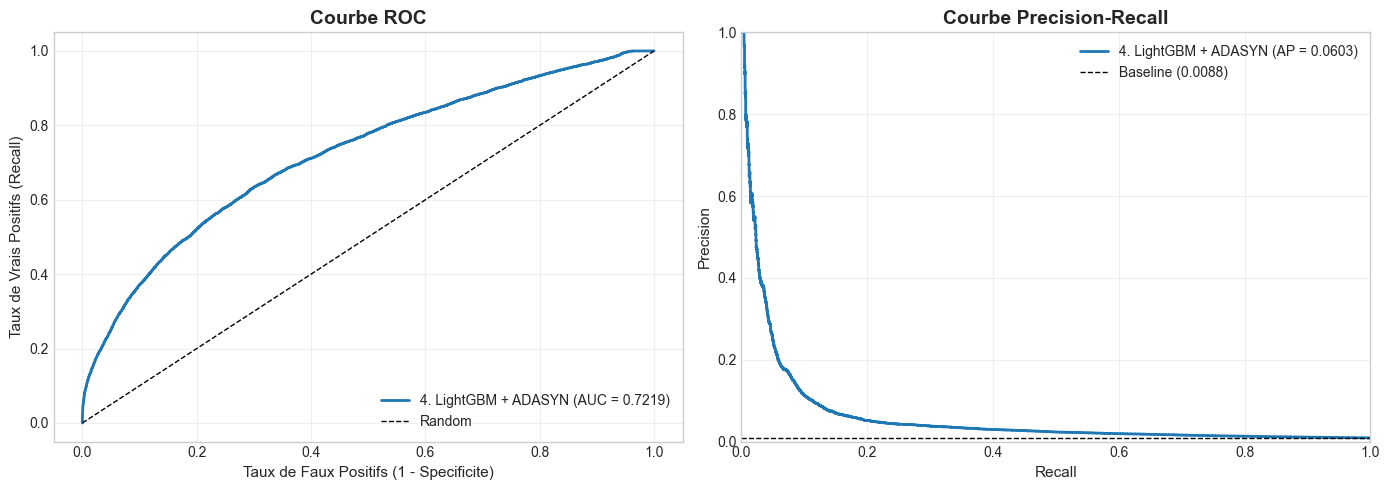

In [21]:
# Courbes ROC et PR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_roc_curve(y_test, y_proba_best, best_model_name, ax=axes[0])
plot_precision_recall_curve(y_test, y_proba_best, best_model_name, ax=axes[1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'best_model_curves.png', dpi=300, bbox_inches='tight')
plt.show()

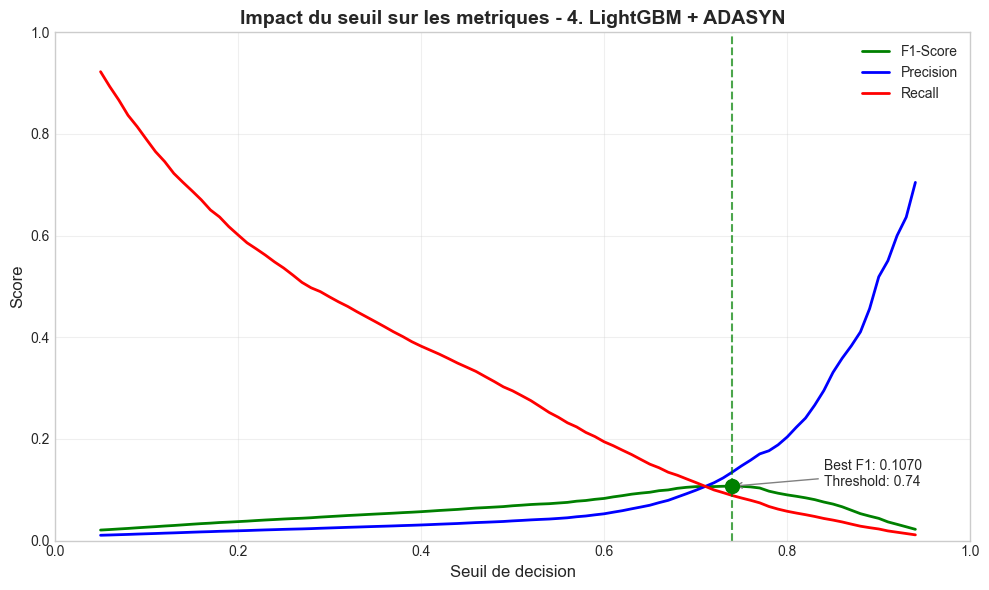


Seuil optimal: 0.74
F1-Score avec seuil optimal: 0.1070


In [22]:
# Analyse du seuil optimal
best_threshold, best_f1_optimized = plot_threshold_analysis(
    y_test, y_proba_best, best_model_name, save=True
)

print(f"\nSeuil optimal: {best_threshold:.2f}")
print(f"F1-Score avec seuil optimal: {best_f1_optimized:.4f}")

In [23]:
# Evaluation avec le seuil optimise
y_pred_optimized = (y_proba_best >= best_threshold).astype(int)
metrics_optimized = compute_all_metrics(y_test, y_pred_optimized, y_proba_best)
print_metrics(metrics_optimized, f"{best_model_name} (seuil={best_threshold:.2f})")


RESULTATS: 4. LightGBM + ADASYN (seuil=0.74)

[Matrice de confusion]
   TP (Fraudes detectees):            583
   TN (Normales correctes):       737,094
   FP (Fausses alertes):            3,744
   FN (Fraudes manquees):           5,990

[Metriques principales]
   F1-Score:    0.1070  <-- METRIQUE A OPTIMISER
   Precision:   0.1347
   Recall:      0.0887
   Accuracy:    0.9870
   Specificite: 0.9949

[Metriques probabilistes]
   ROC-AUC:     0.7219
   Avg Prec:    0.0603


## 11. Importance des features


Importance des features:
       feature  importance
 TauxImpNB_CPM        1283
  TauxImpNb_RB         329
    ScoringFP3         192
          D2CB         176
       Montant         145
    ScoringFP1         128
    ScoringFP2         126
   DiffDateTr1         105
  EcartNumCheq          81
         CA3TR          66
VerifianceCPT3          65
   DiffDateTr3          59
   DiffDateTr2          58
    CA3TRetMtt          58
         Heure          57
VerifianceCPT1          49
  NbrMagasin3J          20
VerifianceCPT2           3


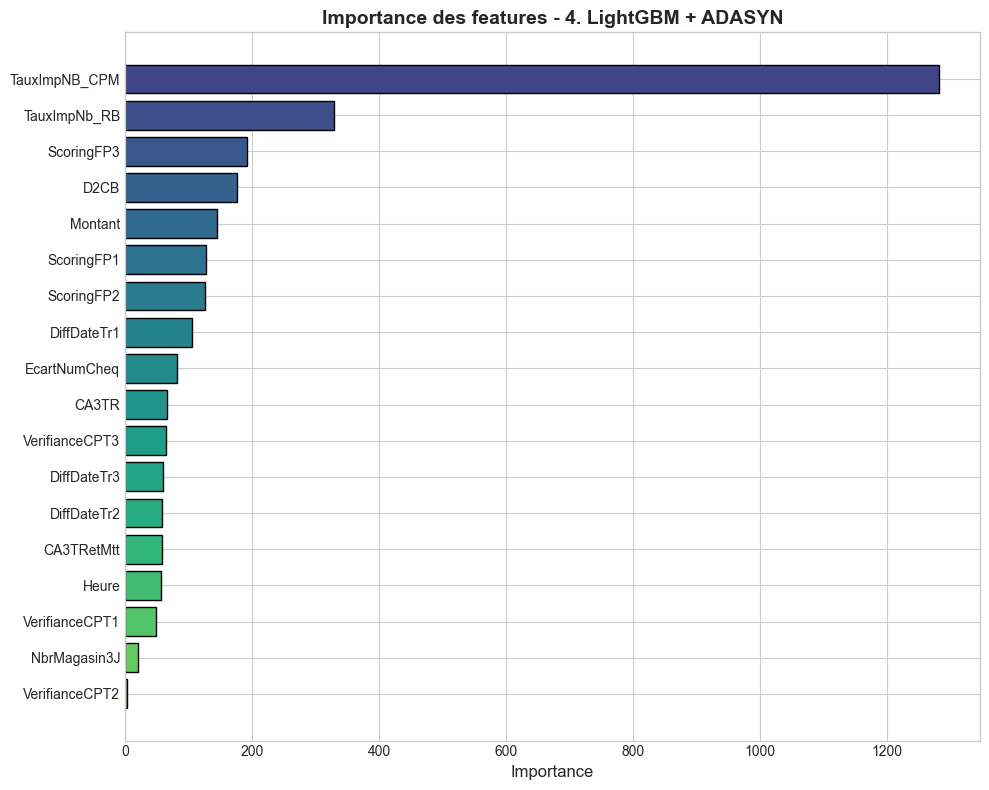

In [24]:
# Importance des features (si le modele le supporte)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nImportance des features:")
    print(feature_importance.to_string(index=False))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
    bars = ax.barh(feature_importance['feature'], feature_importance['importance'], 
                   color=colors, edgecolor='black')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Importance des features - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

## 12. Sauvegarde du meilleur modele

In [25]:
import joblib

# Sauvegarder le meilleur modele
model_filename = MODELS_DIR / 'best_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Modele sauvegarde: {model_filename}")

# Sauvegarder les resultats
results_df = comparison_df.copy()
results_df.to_csv(MODELS_DIR / 'model_comparison_results.csv', index=False)
print(f"Resultats sauvegardes: {MODELS_DIR / 'model_comparison_results.csv'}")

Modele sauvegarde: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\models\best_model.joblib
Resultats sauvegardes: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\models\model_comparison_results.csv


## 13. Resume des resultats

In [26]:
print("\n" + "="*80)
print("RESUME FINAL - PARTIE 1 (Optimisation F-mesure)")
print("="*80)

print(f"\n[DONNEES]")
print(f"   Train: {len(y_train):,} transactions ({y_train.sum():,} fraudes, {y_train.mean()*100:.2f}%)")
print(f"   Test:  {len(y_test):,} transactions ({y_test.sum():,} fraudes, {y_test.mean()*100:.2f}%)")

print(f"\n[METHODES TESTEES]")
for i, (name, metrics) in enumerate(all_results.items(), 1):
    print(f"   {name}: F1={metrics['f1_score']:.4f}")

print(f"\n[MEILLEUR MODELE]")
print(f"   Methode: {best_model_name}")
print(f"   F1-Score (seuil 0.5): {all_results[best_model_name]['f1_score']:.4f}")
print(f"   F1-Score (seuil optimal {best_threshold:.2f}): {best_f1_optimized:.4f}")
print(f"   Precision: {all_results[best_model_name]['precision']:.4f}")
print(f"   Recall: {all_results[best_model_name]['recall']:.4f}")
print(f"   ROC-AUC: {all_results[best_model_name]['roc_auc']:.4f}")

print(f"\n[FRAUDES DETECTEES]")
tp = metrics_optimized['TP']
fn = metrics_optimized['FN']
total_frauds = tp + fn
print(f"   Detectees: {tp:,} / {total_frauds:,} ({tp/total_frauds*100:.1f}%)")
print(f"   Manquees:  {fn:,} / {total_frauds:,} ({fn/total_frauds*100:.1f}%)")

print(f"\n[FAUSSES ALERTES]")
fp = metrics_optimized['FP']
tn = metrics_optimized['TN']
print(f"   Fausses alertes: {fp:,}")
print(f"   Taux: {fp/(fp+tn)*100:.2f}% des transactions normales")




RESUME FINAL - PARTIE 1 (Optimisation F-mesure)

[DONNEES]
   Train: 3,899,362 transactions (23,422 fraudes, 0.60%)
   Test:  747,411 transactions (6,573 fraudes, 0.88%)

[METHODES TESTEES]
   1. RF Baseline: F1=0.0359
   2. RF + SMOTE: F1=0.0483
   3. XGBoost Weighted: F1=0.0346
   4. LightGBM + ADASYN: F1=0.0685
   5. RF + UnderSampling: F1=0.0465

[MEILLEUR MODELE]
   Methode: 4. LightGBM + ADASYN
   F1-Score (seuil 0.5): 0.0685
   F1-Score (seuil optimal 0.74): 0.1070
   Precision: 0.0388
   Recall: 0.2947
   ROC-AUC: 0.7219

[FRAUDES DETECTEES]
   Detectees: 583 / 6,573 (8.9%)
   Manquees:  5,990 / 6,573 (91.1%)

[FAUSSES ALERTES]
   Fausses alertes: 3,744
   Taux: 0.51% des transactions normales
